In [ ]:
# !pip install wandb

In [1]:
import os
import datetime
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/Deep Learning CS6910')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
CS6910_Assignment_2_part_a.ipynb  nature_12K.zip  wandb
inaturalist_12K			  trained_models


In [2]:
# !unzip nature_12K.zip

In [33]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import numpy as np
import wandb
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


In [4]:

# Define the data transforms for resizing and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the images to 224 x 224
    transforms.ToTensor(),  # convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize the images
])

# Define the paths to the train and test data folders
train_data_path = './inaturalist_12K/train'
test_data_path = './inaturalist_12K/val'

# Load the train and test data using the ImageFolder dataset
train_data = ImageFolder(root=train_data_path, transform=transform)
test_data = ImageFolder(root=test_data_path, transform=transform)

# Split the train data into train and validation sets (80/20 split)
train_data, val_data = random_split(train_data, [int(0.8*len(train_data)), len(train_data)-int(0.8*len(train_data))])

# Define the batch size for the data loader
batch_size = 16

# Create data loaders for the train, validation, and test data
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [5]:
len(train_loader),len(val_loader),len(test_loader)

(539, 135, 125)

In [6]:
# class CustomCNN(nn.Module):
#   def __init__(self,lr=1e-3,in_channels=3,num_classes=10,hidden_dims=1000,filter_list=[8,16,32,64,128],kernel_size=[3,3,3,3,3],activation='relu'):
#     super(CustomCNN, self).__init__()


#     self.conv1 = nn.Conv2d(in_channels,filter_list[0],kernel_size[0],1)
#     self.max_pool = nn.MaxPool2d(2,2)
#     self.conv2 = nn.Conv2d(filter_list[0],filter_list[1],kernel_size[1],1)
#     self.conv3 = nn.Conv2d(filter_list[1],filter_list[2],kernel_size[2],1)
#     self.conv4 = nn.Conv2d(filter_list[2],filter_list[3],kernel_size[3],1)
#     self.conv5 = nn.Conv2d(filter_list[3],filter_list[4],kernel_size[4],1)
#     self.activation = nn.ReLU()

#     self.fc1 = nn.Linear(3200,hidden_dims)
#     self.fc2 = nn.Linear(hidden_dims,num_classes)
#     self.softmax = nn.Softmax(dim=1)

#     self.optimizer = optim.Adam(self.parameters(), lr=lr)
#     self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     self.to(self.device)

#   def forward(self,inputs):
#     x = self.conv1(inputs)
#     x = self.relu(x)
#     x = self.max_pool(x)

#     x = self.conv2(x)
#     x = self.relu(x)
#     x = self.max_pool(x)

#     x = self.conv3(x)
#     x = self.relu(x)
#     x = self.max_pool(x)

#     x = self.conv4(x)
#     x = self.relu(x)
#     x = self.max_pool(x)

#     x = self.conv5(x)
#     x = self.relu(x)
#     x = self.max_pool(x)
#     x = torch.flatten(x,start_dim=1)
#     x = self.fc1(x)
#     x = self.softmax(x)

#     return x


In [7]:
# class CustomCNN(nn.Module):
#   def __init__(self,lr=1e-3,in_channels=3,num_classes=10,hidden_dims=256,filter_list=[8,16,32,64,128],kernel_size=[3,3,3,3,3],conv_act='relu',fc_act='relu'):
#     super(CustomCNN, self).__init__()

#     filter_in,filter_out = [],filter_list

#     filter_in.append(in_channels)
#     for idx in range(len(filter_list)-1):
#       filter_in.append(filter_list[idx])

#     print(filter_in,filter_out)

#     self.convs = nn.ModuleList([nn.Conv2d(filter_in[idx],filter_out[idx],kernel_size[idx],1) for idx in range(5)])
#     self.max_pool = nn.MaxPool2d(2,2)

#     if conv_act == 'relu':
#       self.conv_act = nn.ReLU()
#     elif conv_act == 'leaky_relu':
#       self.conv_act == nn.LeakyReLU()
#     elif conv_act == 'mish':
#       self.conv_act = nn.Mish()
#     elif conv_act == 'gelu':
#       self.conv_act == nn.GELU()
#     elif conv_act == 'silu':
#       self.conv_act = nn.SiLU()

#     if fc_act == 'relu':
#       self.fc_act = nn.ReLU()
#     elif fc_act == 'leaky_relu':
#       self.fc_act == nn.LeakyReLU()
#     elif fc_act == 'mish':
#       self.fc_act = nn.Mish()
#     elif fc_act == 'gelu':
#       self.fc_act == nn.GELU()
#     elif fc_act == 'silu':
#       self.fc_act = nn.SiLU()

#     fc_dims = self.find_linear_dim()
#     self.fc1 = nn.Linear(fc_dims,hidden_dims)
#     self.fc2 = nn.Linear(hidden_dims,num_classes)
#     self.softmax = nn.Softmax(dim=1)

#     self.optimizer = optim.Adam(self.parameters(), lr=lr)
#     self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     self.to(self.device)
  
#   def find_linear_dim(self):
#     x = torch.zeros(1,3,224,224)
#     for idx in range(5):
#       x = self.convs[idx](x)
#       x = self.conv_act(x)
#       x = self.max_pool(x)
    
#     x = torch.flatten(x,start_dim=1)
#     return x.shape[1]

#   def forward(self,x):

#     for idx in range(5):
#       x = self.convs[idx](x)
#       x = self.conv_act(x)
#       x = self.max_pool(x)

#     x = torch.flatten(x,start_dim=1)
#     x = self.fc1(x)
#     x = self.fc_act(x)

#     x = self.fc2(x)
#     x = self.softmax(x)

#     return x


In [8]:
# model = CustomCNN(lr=1e-3)
# criterion = nn.CrossEntropyLoss()
# model

In [9]:
# # Train the model
# for epoch in range(10):  # loop over the dataset multiple times

#   running_loss = 0.0
#   correct = 0
#   total = 0
#   for i, data in enumerate(train_loader, 0):
#     # get the inputs; data is a list of [inputs, labels]
#     inputs, labels = data
#     inputs,labels = inputs.to(model.device), labels.to(model.device)

#     # zero the parameter gradients
#     model.optimizer.zero_grad()

#     # forward + backward + optimize
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     model.optimizer.step()

#     running_loss += loss.item()
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()

#   print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader):.4f}, Accuracy = {(100 * correct / total):.2f}%")

#   # Validation loop
#   with torch.no_grad():
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for inputs, labels in val_loader:
#       inputs,labels = inputs.to(model.device),labels.to(model.device)
#       outputs = model(inputs)
#       loss = criterion(outputs, labels)
      
#       running_loss += loss.item()
#       _, predicted = torch.max(outputs.data, 1)
#       total += labels.size(0)
#       correct += (predicted == labels).sum().item()
      
#     # Print validation statistics
#     print(f"Validation: Loss = {running_loss/len(val_loader):.4f}, Accuracy = {(100 * correct / total):.2f}%")

# print('Finished Training')

In [10]:
class CustomCNN(nn.Module):
  def __init__(self,lr=1e-3,in_channels=3,num_classes=10,hidden_dims=256,filter_size=8,filter_org='double_up',kernel_size=[3,3,3,3,3],\
               conv_act='relu',fc_act='relu',batch_norm='no',dropout=0.2):
    super(CustomCNN, self).__init__()

    filter_list = []
    if filter_org == 'double_up':
      for idx in range(5):
        filter_list.append(filter_size*(2**idx))
    elif filter_org == 'double_down':
      for idx in range(5):
        filter_list.append(max(filter_size//(2**idx),2))
    elif filter_org == 'same':
      filter_list = list(filter_size*np.ones(5,dtype=np.uint8))

    filter_in,filter_out = [],filter_list

    filter_in.append(in_channels)
    for idx in range(len(filter_list)-1):
      filter_in.append(filter_list[idx])

    self.convs = nn.ModuleList([nn.Conv2d(filter_in[idx],filter_out[idx],kernel_size[idx],1) for idx in range(5)])
    self.batch_norms = nn.ModuleList([nn.BatchNorm2d(filter_out[idx]) for idx in range(5)])
    # self.drops = nn.ModuleList([nn.Dropout(dropout) for _ in range(5)])
    self.dropout = nn.Dropout(dropout)
    self.max_pool = nn.MaxPool2d(2,2)

    if conv_act == 'relu':
      self.conv_act = nn.ReLU()
    elif conv_act == 'leaky_relu':
      self.conv_act = nn.LeakyReLU()
    elif conv_act == 'mish':
      self.conv_act = nn.Mish()
    elif conv_act == 'gelu':
      self.conv_act = nn.GELU()
    elif conv_act == 'silu':
      self.conv_act = nn.SiLU()


    if fc_act == 'relu':
      self.fc_act = nn.ReLU()
    elif fc_act == 'leaky_relu':
      self.fc_act = nn.LeakyReLU()
    elif fc_act == 'mish':
      self.fc_act = nn.Mish()
    elif fc_act == 'gelu':
      self.fc_act = nn.GELU()
    elif fc_act == 'silu':
      self.fc_act = nn.SiLU()

    fc_dims = self.find_linear_dim()
    self.fc1 = nn.Linear(fc_dims,hidden_dims)
    self.fc2 = nn.Linear(hidden_dims,num_classes)
    self.softmax = nn.Softmax(dim=1)

    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.criterion = nn.CrossEntropyLoss()
    self.to(self.device)
  
  def find_linear_dim(self):
    x = torch.zeros(1,3,224,224)
    for idx in range(5):
      x = self.convs[idx](x)      
      x = self.conv_act(x)      
      x = self.max_pool(x)
    
    x = torch.flatten(x,start_dim=1)
    return x.shape[1]

  def forward(self,x):

    for idx in range(5):
      x = self.convs[idx](x)
      x = self.batch_norms[idx](x)
      x = self.conv_act(x)
      x = self.max_pool(x)

    x = torch.flatten(x,start_dim=1)
    x = self.fc1(x)
    x = self.fc_act(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.softmax(x)

    return x


In [ ]:
# model = CustomCNN(conv_act='leaky_relu')
# model

In [ ]:
# # Train the model
# for epoch in range(10):  # loop over the dataset multiple times

#   running_loss = 0.0
#   correct = 0
#   total = 0
#   for i, data in enumerate(train_loader, 0):
#     # get the inputs; data is a list of [inputs, labels]
#     inputs, labels = data
#     inputs,labels = inputs.to(model.device), labels.to(model.device)

#     # zero the parameter gradients
#     model.optimizer.zero_grad()

#     # forward + backward + optimize
#     outputs = model(inputs)
#     loss = model.criterion(outputs, labels)
#     loss.backward()
#     model.optimizer.step()

#     running_loss += loss.item()
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()

#   print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader):.4f}, Accuracy = {(100 * correct / total):.2f}%")

#   # Validation loop
#   with torch.no_grad():
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for inputs, labels in val_loader:
#       inputs,labels = inputs.to(model.device),labels.to(model.device)
#       outputs = model(inputs)
#       loss = model.criterion(outputs, labels)
      
#       running_loss += loss.item()
#       _, predicted = torch.max(outputs.data, 1)
#       total += labels.size(0)
#       correct += (predicted == labels).sum().item()
      
#     # Print validation statistics
#     print(f"Validation: Loss = {running_loss/len(val_loader):.4f}, Accuracy = {(100 * correct / total):.2f}%")

# print('Finished Training')

In [13]:
def learn(model,train_loader,val_loader,verbose=False):
  log={}
  # Train the model
  model.train()
  for epoch in tqdm(range(10),ncols=120):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for inputs,labels in train_loader:
      # get the inputs; data is a list of [inputs, labels]
      inputs,labels = inputs.to(model.device), labels.to(model.device)

      # zero the parameter gradients
      model.optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = model.criterion(outputs, labels)
      loss.backward()
      model.optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    
    if verbose:
      print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader):.4f}, Accuracy = {(100 * correct / total):.2f}%")
    log['train_loss'] = running_loss/len(train_loader)
    log['train_acc'] = 100 * correct / total
    
    # Validation loop
    model.eval()
    with torch.no_grad():
      running_loss = 0.0
      correct = 0
      total = 0
      
      for inputs, labels in val_loader:
        inputs,labels = inputs.to(model.device),labels.to(model.device)
        outputs = model(inputs)
        loss = model.criterion(outputs, labels)
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
      # Print validation statistics
      if verbose:
        print(f"Validation: Loss = {running_loss/len(val_loader):.4f}, Accuracy = {(100 * correct / total):.2f}%")
      log['val_loss'] = running_loss/len(train_loader)
      log['val_acc'] = 100 * correct / total

    if verbose == False:
      wandb.log(log)

  print('Finished Training')

In [14]:
sweep_config = {
    'method': 'bayes', 
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'   
    },
    'parameters': {
        'dropout': {
            'values': [0.2, 0.3]
        },
        'batch_norm': {
            'values': ['yes', 'no']
        },
        'filter_size': {
            'values': [64, 128]
        
        },
        'batch_size': {
            'values': [16,32,64]
        },
        'filter_org': {
            'values': ['same', 'double_up', 'double_down']
        },
        'data_aug': {
            'values': ['yes', 'no']
        },
        'lr': {
            'values': [0.1,0.01,1e-3] 
        },
        'hidden_dims': {
            'values': [128,256] 
        },
        'conv_act':{
            'values':['relu','leaky_relu','gelu','mish','silu']
        }
    }
}

In [15]:
sweep_id = wandb.sweep(sweep_config, entity='viswa_ee', project="CS6910_cnn_inat")

Create sweep with ID: 9f4n1mhk
Sweep URL: https://wandb.ai/viswa_ee/CS6910_cnn_inat/sweeps/9f4n1mhk


In [16]:
def train():
  # Default values for hyper-parameters we're going to sweep over
  config_defaults = {
      'batch_norm': 'Yes',
      'filter_org': 'double_up',
      'data_aug': 'yes',
      'batch_size': 16,
      'lr': 1e-1,
      'hidden_dims':128,
      'dropout': 0.2,
  }

  # Initialize a new wandb run
  wandb.init(config=config_defaults)
   
  # Config is a variable that holds and saves hyperparameters and inputs
  config = wandb.config

  train_data_path = './inaturalist_12K/train'
                              
  if config.data_aug == 'yes':
    train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the images to 224 x 224
    transforms.ToTensor(),  # convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize the images
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip()
    ])
                                           
  else:
    train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the images to 224 x 224
    transforms.ToTensor(),  # convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize the images
    ])
  train_data = ImageFolder(root=train_data_path, transform=train_transforms)
  train_data, val_data = random_split(train_data, [int(0.8*len(train_data)), len(train_data)-int(0.8*len(train_data))])

  # Define the batch size for the data loader
  batch_size = config.batch_size

  # Create data loaders for the train, validation, and test data
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size)
  model = CustomCNN(lr=config.lr,hidden_dims=config.hidden_dims,filter_size=config.filter_size,filter_org=config.filter_org,conv_act=config.conv_act,\
                    batch_norm=config.batch_norm,dropout=config.dropout)
  print('.... Model Created .....')
  print(model)
  # start = time.time()
  learn(model,train_loader,val_loader)
  print('.. saving .. ')
  torch.save(model.state_dict(), './trained_models/'+wandb.run.name+'.pt')
  # print('time taken: ',time.time()-start,'s')
  torch.cuda.empty_cache()


In [ ]:
wandb.agent(sweep_id,function=train,count=20)

In [35]:
def plot_img(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [63]:
def test(model,data_aug,batch_size,verbose=False):
  test_data_path = './inaturalist_12K/val'

  if data_aug == 'yes':
    test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the images to 224 x 224
    transforms.ToTensor(),  # convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize the images
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip()
    ])
                                           
  else:
    test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the images to 224 x 224
    transforms.ToTensor(),  # convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize the images
    ])
  
  test_data = ImageFolder(root=train_data_path, transform=test_transforms)
  test_loader = DataLoader(test_data, batch_size=batch_size)

  log={}
  # Testing loop
  model.eval()
  with torch.no_grad():
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
      inputs,labels = inputs.to(model.device),labels.to(model.device)
      outputs = model(inputs)
      loss = model.criterion(outputs, labels)
      
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
    # Print validation statistics
    if verbose:
      print(f"Test: Loss = {running_loss/len(val_loader):.4f}, Accuracy = {(100 * correct / total):.2f}%")
    log['test_loss'] = running_loss/len(train_loader)
    log['test_acc'] = 100 * correct / total
  print(log)
  
  print('Finished Testing .. ')
  classes = ['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
  dataiter = iter(test_loader)
  inputs, labels = next(dataiter)
  inputs = inputs.cuda()
  output = model(inputs)
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.cpu().numpy())

  fig = plt.figure(figsize=(9, 25))
  for idx in np.arange(30):
      ax = fig.add_subplot(10, 3, idx+1, xticks=[], yticks=[])
      plot_img(inputs.cpu()[idx])
      ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                  color=("green" if preds[idx]==labels[idx].item() else "red"))

In [61]:
model = CustomCNN(lr=0.001,hidden_dims=256,filter_size=128,filter_org='double_down',conv_act='mish',\
                    batch_norm='no',dropout=0.2)
print('.. loading ...')
model.load_state_dict(torch.load('./trained_models/zesty-sweep-9.pt'))

.. loading ...


<All keys matched successfully>

{'test_loss': 1.306973283719928, 'test_acc': 36.54525181193087}
Finished Testing .. 


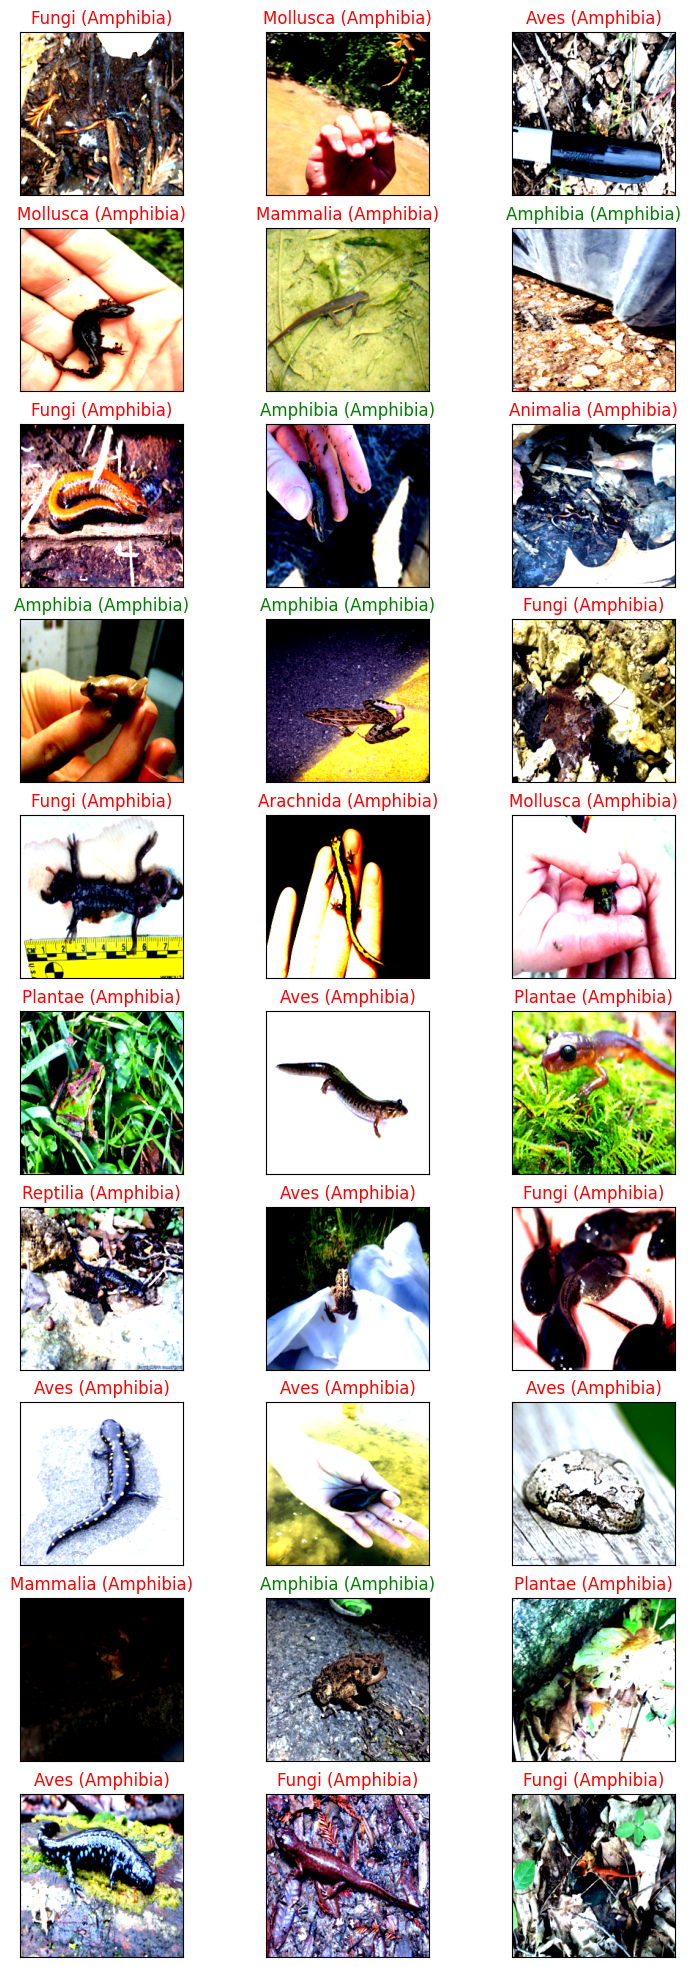

In [64]:
test(model,'no',32)

In [53]:

test_data_path = './inaturalist_12K/val'

test_transforms = transforms.Compose([
transforms.Resize((224, 224)),  # resize the images to 224 x 224
transforms.ToTensor(),  # convert the images to PyTorch tensors
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize the images
])

test_data = ImageFolder(root=train_data_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32)



In [54]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.cuda()

In [55]:
output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())